In [1]:
!git clone https://github.com/amirberenji1995/damavand

fatal: destination path 'damavand' already exists and is not an empty directory.


In [2]:
!pip install -r damavand/requirements.txt

# Signal Processing - 101
This notebook is a brief introduction to **Signal Processing** for vibration data analysis, with a focus on its application in rotating machinery condition monitoring.

## 1. Signal Processing: Unlocking Insights from Vibration Data

Vibration data from rotating machinery is a goldmine of information, but it's hidden in noise and complexity.  Signal processing is the key to unlocking this information.  Think of it as translating the machine's "language" of vibrations into a clear, understandable message about its health.

We start with the **signal** itself—a representation of vibration over time, either as a continuous analog wave or a discrete digital sequence.  Signal processing then uses various techniques to enhance and analyze this signal:

* **Time-domain analysis:** Looking directly at the signal's shape over time.  Think of it like reading a story—we look for sudden changes, repeating patterns, or unusual spikes.
* **Frequency-domain analysis (FFT):** Transforming the signal to see its hidden frequencies.  This is like musical analysis—we identify the dominant notes (frequencies) that reveal the machine's internal workings and potential problems.
* **Filtering:** Cleaning up the signal by removing unwanted noise. This is like editing a recording—we remove background noise to hear the main instrument clearly.

By combining these techniques, we can extract crucial features from the vibration data, such as characteristic frequencies associated with specific faults, enabling early detection and diagnosis of problems.  This allows for proactive maintenance, preventing costly breakdowns and ensuring operational efficiency.  This notebook explores these techniques and how they are applied using [Package Name] to analyze vibration data and improve rotating machinery reliability.

## 2. Essential Theory

### 2.1 Sampling of Vibration Signals

Real-world vibration signals are continuous-time and analog.  Digital processing requires sampling—converting the signal into a discrete-time sequence by measuring amplitude at regular intervals determined by the sampling frequency, *f<sub>s</sub>*, with sampling interval *T<sub>s</sub> = 1/f<sub>s</sub>*.

![Sampling illustration](https://static.wikia.nocookie.net/ultimatepopculture/images/5/50/Signal_Sampling.png/revision/latest/scale-to-width-down/500?cb=20200801150448)

### 2.2 Nyquist-Shannon Sampling Theorem

Aliasing is phenomena which causes higher frequencies to appear as lower ones in the sampled data.

![Aliasing illustration](https://matthews.sites.wfu.edu/misc/DigPhotog/alias/alias.png)

To avoid information loss (aliasing), the sampling frequency must be at least twice the maximum frequency present in the signal (*f<sub>s</sub> ≥ 2f<sub>max</sub>*). Anti-aliasing filters are used before sampling to remove frequencies above *f<sub>max</sub>*.

### 2.3 Leakage Error

Leakage error arises in frequency spectrum analysis when the analyzed signal's duration is not an integer multiple of its fundamental period. This discontinuity at the observation window's edges causes spectral energy to "leak" into adjacent frequency bins, blurring the true frequency components and distorting their amplitudes.

Windowing techniques (e.g., Hanning, Hamming) mitigate this by smoothly tapering the signal's ends, reducing the discontinuity and minimizing spectral leakage.


### 2.4 Modulation and Demodulation

Modulation modifies a carrier signal's properties using a message signal.  In Amplitude Modulation (AM), the modulated signal is:  *s(t) = A<sub>c</sub>[1 + m(t)]cos(2πf<sub>c</sub>t)*, where *A<sub>c</sub>* and *f<sub>c</sub>* are the carrier's amplitude and frequency, and *m(t)* is the message signal.

![Modulation illustration](https://www.watelectronics.com/wp-content/uploads/Basic-Amplitude-Modulation-Wave.png)

In RCM, machine speed variations modulate fault frequencies. Demodulation thecniques (etc. envelope extraction using Hilbert transform) recovers the message signal.

### 2.5 Frequency Filtering

Filtering selectively removes or attenuates specific frequency components.  Common filter types include:

*   **Low-pass filters:** Pass frequencies below a cutoff frequency and attenuate higher frequencies.
*   **High-pass filters:** Pass frequencies above a cutoff frequency and attenuate lower frequencies.
*   **Band-pass filters:** Pass frequencies within a specific band and attenuate frequencies outside this band.
*   **Band-stop filters (notch filters):** Attenuate frequencies within a specific band and pass frequencies outside this band.

![Frequency filters illustration](https://www.open.edu/openlearn/pluginfile.php/1881285/mod_oucontent/oucontent/95937/1b694830/65562369/t312_openlearn_fig05.tif.jpg)

## 3. Signal Processing using Damavand

Damavand offers two main approaches to process vibration signals:
1. **Applying transformations**: Damavand facilitates the application of the most frequent signal processing transformations.
2. **Fetaure extraction**: In addition to the transformations, Damavand also supports the extraction of expert-defined features.

### 3.1 [Transformations](https://github.com/amirberenji1995/damavand/blob/main/documentations/signal_processing.md#transformations-submodule)

#### 3.1.0 Downloading and Mining the MFPT dataset

In [3]:
from damavand.damavand.datasets.downloaders import read_addresses, ZipDatasetDownloader
from damavand.damavand.datasets.digestors import MFPT
import pandas as pd

# Downloading the MFPT dataset
addresses = read_addresses()
downloader = ZipDatasetDownloader(addresses['MFPT'])
downloader.download_extract('MFPT.zip', 'MFPT/')

mfpt = MFPT('MFPT/MFPT Fault Data Sets/', [
    '1 - Three Baseline Conditions',
    '2 - Three Outer Race Fault Conditions',
    '3 - Seven More Outer Race Fault Conditions',
    '4 - Seven Inner Race Fault Conditions',
])

# Mining the dataset
mining_params = {
    97656: {'win_len': 16671, 'hop_len': 2000},
    48828: {'win_len': 8337, 'hop_len': 1000},
}
mfpt.mine(mining_params)

# Signal/Metadata split
df = pd.concat(mfpt.data[48828]).reset_index(drop = True)
signals, metadata = df.iloc[:, : - 4], df.iloc[:, - 4 :]

#### 3.1.1 [Envelope extraction (Hilbert transform)](https://github.com/amirberenji1995/damavand/blob/main/documentations/signal_processing.md#envsignals)
Extracting the envelope of of signals.

In [4]:
from damavand.damavand.signal_processing.transformations import env

# Envelope extraction
signals_env = env(signals)

#### 3.1.2 [Frequency spectrum extraction (Fast-Fourier Transform)](https://github.com/amirberenji1995/damavand/blob/main/documentations/signal_processing.md#fftsignals-freq_filter--none-window--none)
Applying the Fast-Fourier Transform algorithim to derive frequency domain representation of a set of signals

In [5]:
from scipy.signal.windows import hann
from scipy.signal import butter
from damavand.damavand.signal_processing.transformations import fft

# Defining a window to avoid frequency leakage
window = hann(signals_env.shape[1])
# Defining a bandpass frequency filter to both remove near-DC component and avoid aliasing
freq_filter = butter(25, [5, 23500], 'bandpass', fs = 48828, output='sos')

# Frequency spectra extraction, through FFT
signals_fft = fft(signals, freq_filter = freq_filter, window = window)

#### 3.1.3 [Refined frequency range spectrum extraction (ZoomFFT Algorithm)](https://github.com/amirberenji1995/damavand/blob/main/documentations/signal_processing.md#zoomed_fftsignals-f_min-f_max-desired_len-sampling_freq-freq_filter--none-window--none)
Applying the ZoomFFT algorithm to derive a fine-grained frequency representation in a desired frequency range

In [6]:
from scipy.signal.windows import hann
from scipy.signal import butter
from damavand.damavand.signal_processing.transformations import zoomed_fft

# Defining a window to avoid frequency leakage
window = hann(signals_env.shape[1])
# Defining a bandpass frequency filter to both remove near-DC component and avoid aliasing
freq_filter = butter(25, [5, 23500], 'bandpass', fs = 48828, output='sos')

# Frequency spectra extraction within the range of 0 to 2500 Hz, through zoomed_FFT
signals_ZoomedFFT = zoomed_fft(signals_env, 0, 2500, 2500, 48828, freq_filter = freq_filter, window = window)

#### 3.1.4 [Time-Frequency representation extraction (Short-Time Fourier Transform)](https://github.com/amirberenji1995/damavand/blob/main/documentations/signal_processing.md#stftsignals-window_len-hop_len-freq_filter--none-window--none)
Application of Short-Time Fourier Transform to derive Time-Frequency representation of the inputted signals

In [7]:
from scipy.signal.windows import hann
from scipy.signal import butter
from damavand.damavand.signal_processing.transformations import stft

# Defining a window to avoid frequency leakage (unlike previous transformations, the lenght of the window must match the window_len of the stft)
STFT_window = hann(2400)
# Defining a bandpass frequency filter to both remove near-DC component and avoid aliasing
STFT_freq_filter = butter(25, [5, 23500], 'bandpass', fs = float(metadata.iloc[0, 0]), output='sos')

# Time-Frequency representation extraction using 2400-point long segments and a hop lenght of 200 points.
signals_STFT = stft(signals, 2400, 200, STFT_freq_filter, STFT_window)

The following cells visualize the same observation, under different transformations.

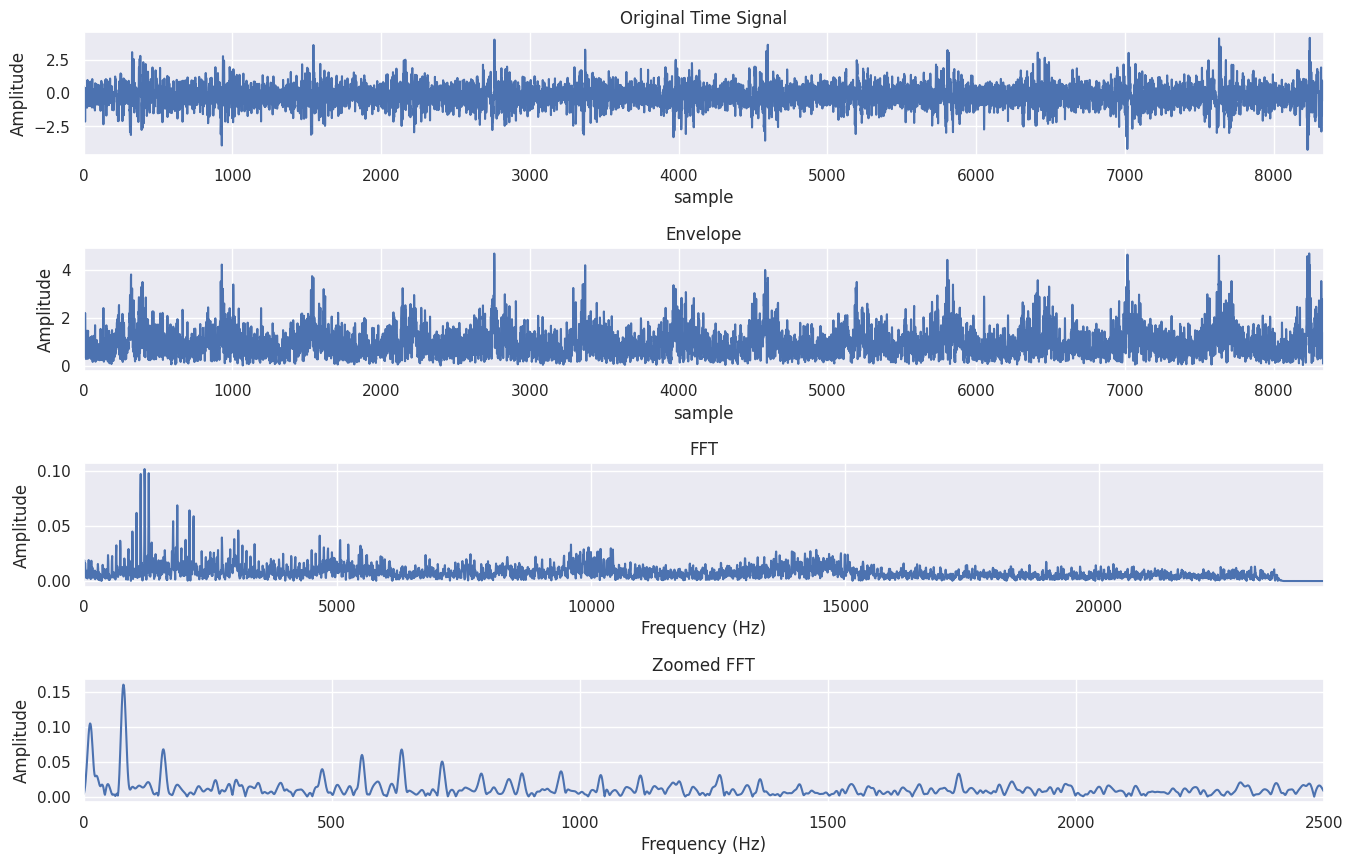

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

from damavand.damavand.utils import *

fig, axes = plt.subplots(4, 1, figsize = (16, 10))

sns.lineplot(ax=axes[0], x=range(len(signals.iloc[0,:])), y = signals.iloc[0,:])
axes[0].set_title("Original Time Signal")
axes[0].set_ylabel("Amplitude")
axes[0].set_xlabel("sample")
axes[0].set_xlim(0, 8337)

sns.lineplot(ax=axes[1], x=range(len(signals_env.iloc[0,:])), y = signals_env.iloc[0, :])
axes[1].set_title("Envelope")
axes[1].set_ylabel("Amplitude")
axes[1].set_xlabel("sample")
axes[1].set_xlim(0, 8337)


sns.lineplot(ax=axes[2], x = fft_freq_axis(8337, 48828), y = signals_fft.iloc[0, :])
axes[2].set_title("FFT")
axes[2].set_ylabel("Amplitude")
axes[2].set_xlabel("Frequency (Hz)")
axes[2].set_xlim(0, 24424)


sns.lineplot(ax=axes[3], x = zoomed_fft_freq_axis(0, 2500, 2500), y = signals_ZoomedFFT.iloc[0, :])
axes[3].set_title("Zoomed FFT")
axes[3].set_ylabel("Amplitude")
axes[3].set_xlabel("Frequency (Hz)")
axes[3].set_xlim(0, 2500)


plt.subplots_adjust(hspace = 0.75)
fig.show()

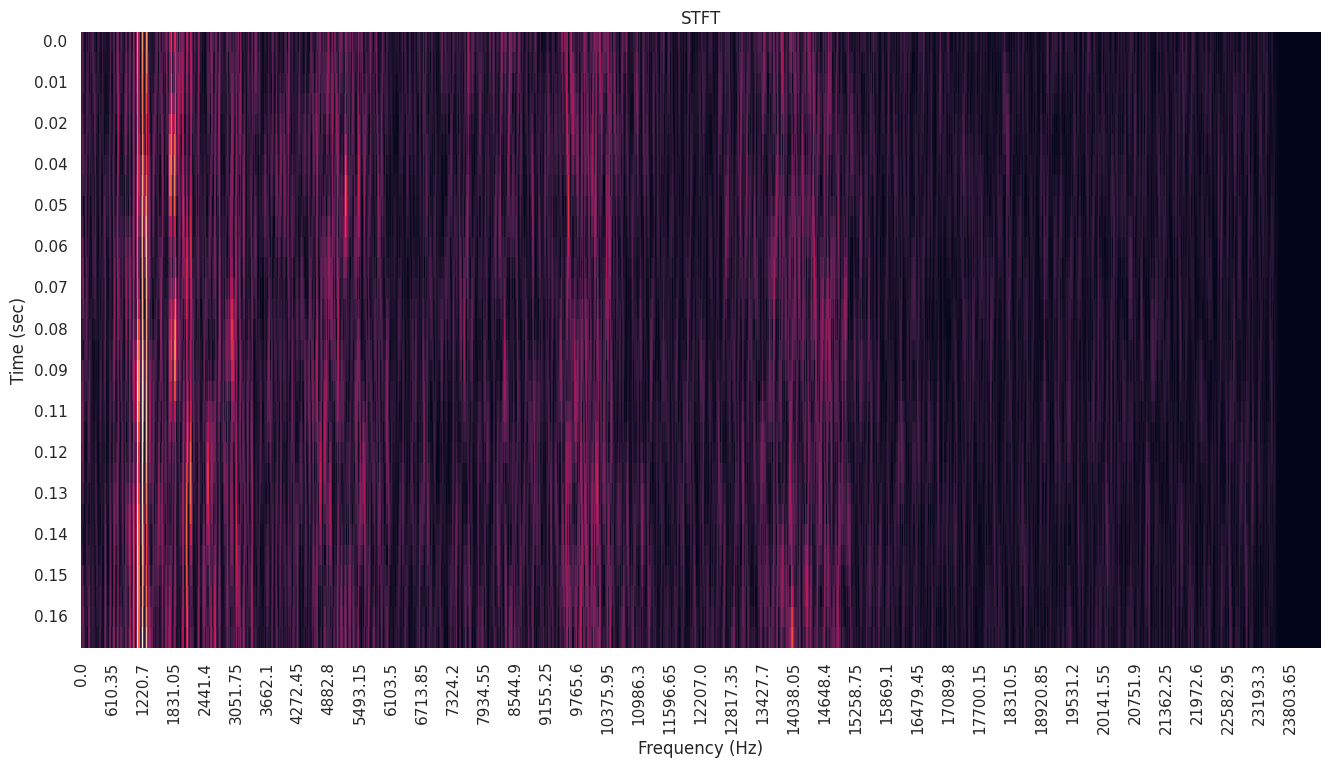

In [9]:
import numpy as np
from damavand.damavand.utils import fft_freq_axis

t = np.linspace(0, 0.1707, 30)
f = fft_freq_axis(2400, 48828)

fig, ax = plt.subplots(figsize = (16, 8))

ax = sns.heatmap(signals_STFT[0, :, :], xticklabels = np.round(f, decimals = 2), yticklabels = np.round(t, decimals = 2), annot = False, cbar = False)
ax.set(xlabel = 'Frequency (Hz)', ylabel = 'Time (sec)')
ax.set_title('STFT')
ax.set_xticks(ax.get_xticks()[::30])
ax.set_yticks(ax.get_yticks()[::2])


fig.show()

### 3.2 [Feature Extraction](https://github.com/amirberenji1995/damavand/blob/main/documentations/signal_processing.md#feature-extraction-submodule)

Hand-crafted features (from both time and frequency domains) are widely used for rotating machinery conidition monitoring. Damavand, facilitates the extraction of such features from raw (time and frequency) data.

Features must be implemented as a Python function; then, they must be passed as key-vlaue pairs of ``` "feature_name": (feature_function, (args), (kwargs)) ``` to the ```feature_extractor``` function, alongside the signal bank.

The following section, demonstrate the extraction of both time and frequency domains, respectively.

#### 3.2.1 Time-domain Features

In [10]:
from damavand.damavand.signal_processing.feature_extraction import *
from numpy import mean, std
from scipy.stats import skew, kurtosis

# Defining the desired features (below is a wide set of time-domain features)
time_features = {
  'mean': (mean, (), {}),
  'std': (std, (), {}),
  'smsa': (smsa, (), {}),
  'rms': (rms, (), {}),
  'peak': (peak, (), {}),
  'skew': (skew, (), {}),
  'kurtosis': (kurtosis, (), {}),
  'crest_factor': (crest_factor, (), {}),
  'clearance_factor': (clearance_factor, (), {}),
  'shape_factor': (shape_factor, (), {}),
  'impulse_factor': (impulse_factor, (), {}),
}

# Extracting the features from the signals
time_features_df = feature_extractor(signals, time_features)
time_features_df

,mean,std,smsa,rms,peak,skew,kurtosis,crest_factor,clearance_factor,shape_factor,impulse_factor
0,-0.184024,0.816661,0.531492,0.837138,4.259008,-0.012312,1.455025,5.087580,8.013310,1.309186,6.660590
1,-0.180836,0.806005,0.527821,0.826042,4.259008,-0.013430,1.443762,5.155922,8.069034,1.304167,6.724184
2,-0.183012,0.827373,0.542704,0.847372,4.259008,-0.016724,1.362095,5.026139,7.847754,1.302203,6.545052
3,-0.178946,0.826251,0.541090,0.845407,4.259008,-0.017216,1.457751,5.037820,7.871167,1.303262,6.565601
4,-0.180836,0.830811,0.546731,0.850263,4.259008,-0.018926,1.333448,5.009045,7.789949,1.298817,6.505832
...,...,...,...,...,...,...,...,...,...,...,...
1941,-0.212814,1.913001,0.700623,1.924802,23.788190,1.280296,35.833671,12.358773,33.952902,1.957477,24.192016
1942,-0.214259,1.927105,0.705142,1.938979,23.788190,1.253180,34.835319,12.268409,33.735319,1.952201,23.950398
1943,-0.210920,2.010897,0.709647,2.021928,23.788190,1.254061,35.683098,11.765102,33.521169,2.003571,23.572221
1944,-0.207534,2.051129,0.721359,2.061601,23.788190,1.225027,33.720097,11.538696,32.976889,2.002352,23.104527


#### 3.2.2 Frequency-domain Features

In [12]:
from scipy.signal.windows import hann
from scipy.signal import butter
from numpy import mean, var
from scipy.stats import skew, kurtosis
from damavand.damavand.signal_processing.feature_extraction import *
from damavand.damavand.utils import *

# Applying the FFT to transform data into frequency-domain
window = hann(signals.shape[1])
freq_filter = butter(25, [5, 12500], 'bandpass', fs = 25600, output='sos')
signals_fft = fft(signals, freq_filter = freq_filter, window = window)

# Extracting frequency axis, as it is essential for some of the features
freq_axis = fft_freq_axis(8337, 48828)

# Defining the desired features (below is a wide set of frequency-domain features)
freq_features = {
  'mean': (mean, (), {}),
  'var': (var, (), {}),
  'skew': (skew, (), {}),
  'kurtosis': (kurtosis, (), {}),
  'spectral_centroid': (spectral_centroid, (freq_axis,), {}),
  'P17': (P17, (freq_axis,), {}),
  'P18': (P18, (freq_axis,), {}),
  'P19': (P19, (freq_axis,), {}),
  'P20': (P20, (freq_axis,), {}),
  'P21': (P21, (freq_axis,), {}),
  'P22': (P22, (freq_axis,), {}),
  'P23': (P23, (freq_axis,), {}),
  'P24': (P24, (freq_axis,), {}),
}

# Extracting the features from the frequency domain signals (assuming that frequency domain signals are stored in signals_fft)
freq_features_df = feature_extractor(signals_fft, freq_features)
freq_features_df

,mean,var,skew,kurtosis,spectral_centroid,P17,P18,P19,P20,P21,P22,P23
0,0.008128,0.000048,3.972099,34.700943,10103.754012,594.861703,12067.302042,3.041661e+08,0.691918,0.058875,3.296088,243.828309
1,0.008224,0.000049,4.226418,39.724596,10101.204514,597.026539,12057.112161,3.035333e+08,0.692054,0.059104,3.284973,242.601454
2,0.008337,0.000052,4.387611,42.846097,10115.274554,599.343719,12058.357781,3.026115e+08,0.693179,0.059251,3.203823,241.252598
3,0.008446,0.000055,4.522593,45.004077,10085.433805,602.427202,12028.582999,3.012369e+08,0.693043,0.059732,3.150419,238.789827
4,0.008544,0.000056,4.704061,47.915756,10064.189983,606.186304,12012.376031,3.003047e+08,0.693183,0.060232,3.074401,234.696083
...,...,...,...,...,...,...,...,...,...,...,...,...
1941,0.017581,0.000211,1.855698,5.432757,9096.302345,865.657575,11196.719650,2.974461e+08,0.649212,0.095166,4.027094,121.352483
1942,0.018051,0.000267,2.143322,7.144127,8743.698604,851.344485,10798.311351,2.840365e+08,0.640721,0.097367,4.327539,126.561441
1943,0.018985,0.000384,2.816263,12.007638,8295.449088,866.144272,10408.203953,2.765825e+08,0.625840,0.104412,4.587824,124.835702
1944,0.019875,0.000496,3.453754,18.189097,8033.496912,891.651113,10224.472190,2.762766e+08,0.615133,0.110992,4.730160,119.649973
